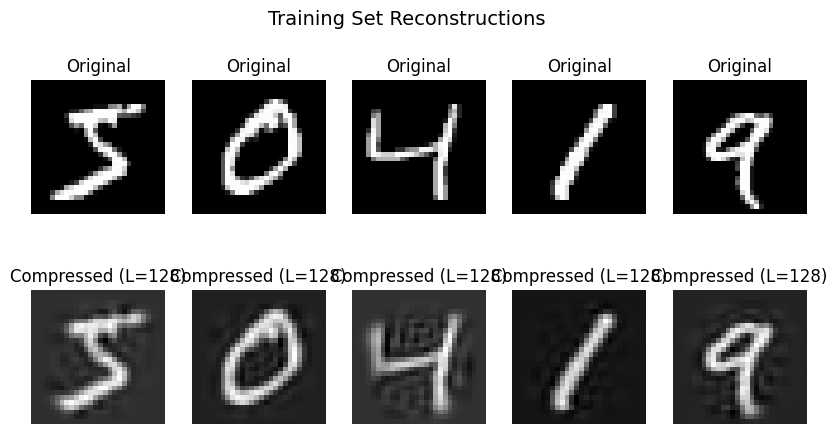

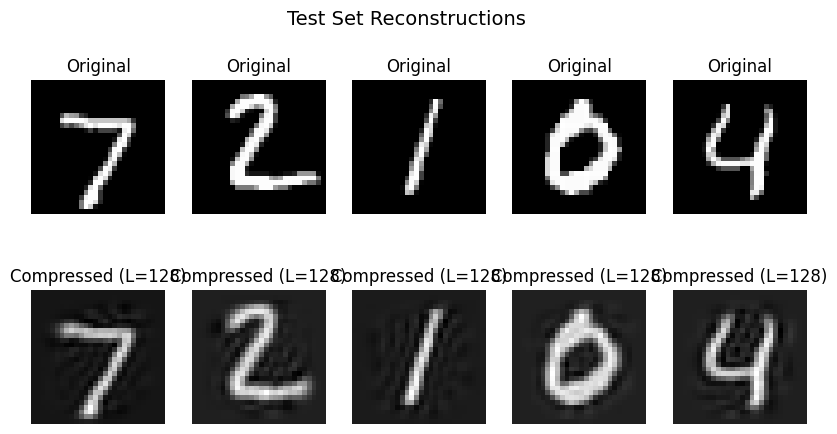

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Load MNIST training and test data
transform = transforms.Compose([transforms.ToTensor()])

mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Extract training and test data as NumPy arrays
train_data = mnist_train.data.numpy().reshape(-1, 28 * 28) / 255.0  # Normalize to [0,1]
test_data = mnist_test.data.numpy().reshape(-1, 28 * 28) / 255.0

# Compute mean image from training data
mean_image = np.mean(train_data, axis=0)

# PCA using SVD (Compute V_L for L=128)
L = 128  # Number of principal components
mean_centered_train = train_data - mean_image  # Centering training data
U, Sigma, Vt = np.linalg.svd(mean_centered_train, full_matrices=False)

V_L = Vt[:L, :] # Select first 128 principal components (V_L)

# (α) Reconstruct compressed training data using V_L
compressed_train = mean_centered_train @ V_L.T  # Project training data onto PCA space
reconstructed_train = (compressed_train @ V_L) + mean_image  # Reconstruct

# (β) Compress and reconstruct test data using the same V_L
mean_centered_test = test_data - mean_image  # Centering test data using training mean
compressed_test = mean_centered_test @ V_L.T  # Project test data onto PCA space
reconstructed_test = (compressed_test @ V_L) + mean_image  # Reconstruct test images

# Function to plot original vs compressed images
def plot_reconstructions(original, reconstructed, num_samples=5, title="Reconstructed Images"):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        # Original image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed image
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.title("Compressed (L=128)")
        plt.axis('off')

    plt.suptitle(title, fontsize=14)
    plt.show()

# Plot reconstructions for training set
plot_reconstructions(train_data, reconstructed_train, num_samples=5, title="Training Set Reconstructions")

# Plot reconstructions for test set
plot_reconstructions(test_data, reconstructed_test, num_samples=5, title="Test Set Reconstructions")


In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Prepare centered training data for the autoencoder (shape: [N, 784])
centered_train = train_data - mean_image  # same as mean_centered_train
train_tensor = torch.from_numpy(centered_train).float()
train_dataset = torch.utils.data.TensorDataset(train_tensor, torch.zeros(len(train_tensor)))
# Use a small batch size to mimic the paper's setting (adjust if needed)
train_loader = DataLoader(train_dataset, batch_size=250, shuffle=True)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

# Define a purely linear autoencoder (no activation functions, no bias)
class LinearAutoencoder(nn.Module):
    def __init__(self, input_size=784, latent_size=128):
        super(LinearAutoencoder, self).__init__()
        # In PyTorch, nn.Linear(in_features, out_features) has weight shape (out_features, in_features)
        self.encoder = nn.Linear(input_size, latent_size, bias=False)
        self.decoder = nn.Linear(latent_size, input_size, bias=False)

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

# Initialize model, loss, and optimizer (using weight decay for L2 regularization)
latent_size = L  # 128
model = LinearAutoencoder(input_size=784, latent_size=latent_size).to(device)
criterion = nn.MSELoss()
learning_rate = 1e-4
regularization = 5e-4  # L2 regularization (weight decay)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization)

linear_losses    = []
# Train the autoencoder
num_epochs = 40   # Increase if needed for convergence
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch, _ in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    linear_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.6f}")

# After training, extract the decoder weights.
# In our PyTorch model, the decoder weight has shape (input_size, latent_size) = (784, 128).
# To mimic the Keras code, we use the transpose so that we get a (latent_size, 784) matrix.
w2 = model.decoder.weight.data.cpu().numpy()  # shape: (784, 128)
w2_transposed = w2.T  # shape: (128, 784)


Training on device: cuda
Epoch [1/40], Loss: 0.000221
Epoch [2/40], Loss: 0.000127
Epoch [3/40], Loss: 0.000098
Epoch [4/40], Loss: 0.000085
Epoch [5/40], Loss: 0.000080
Epoch [6/40], Loss: 0.000077
Epoch [7/40], Loss: 0.000076
Epoch [8/40], Loss: 0.000075
Epoch [9/40], Loss: 0.000074
Epoch [10/40], Loss: 0.000074
Epoch [11/40], Loss: 0.000074
Epoch [12/40], Loss: 0.000074
Epoch [13/40], Loss: 0.000074
Epoch [14/40], Loss: 0.000074
Epoch [15/40], Loss: 0.000074
Epoch [16/40], Loss: 0.000074
Epoch [17/40], Loss: 0.000074
Epoch [18/40], Loss: 0.000074
Epoch [19/40], Loss: 0.000074
Epoch [20/40], Loss: 0.000074
Epoch [21/40], Loss: 0.000074
Epoch [22/40], Loss: 0.000074
Epoch [23/40], Loss: 0.000074
Epoch [24/40], Loss: 0.000074
Epoch [25/40], Loss: 0.000074
Epoch [26/40], Loss: 0.000074
Epoch [27/40], Loss: 0.000074
Epoch [28/40], Loss: 0.000074
Epoch [29/40], Loss: 0.000074
Epoch [30/40], Loss: 0.000074
Epoch [31/40], Loss: 0.000074
Epoch [32/40], Loss: 0.000074
Epoch [33/40], Loss: 0.0

W2 shape: (784, 128)


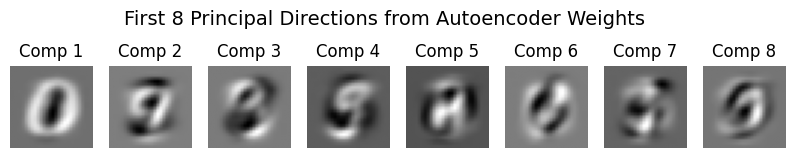

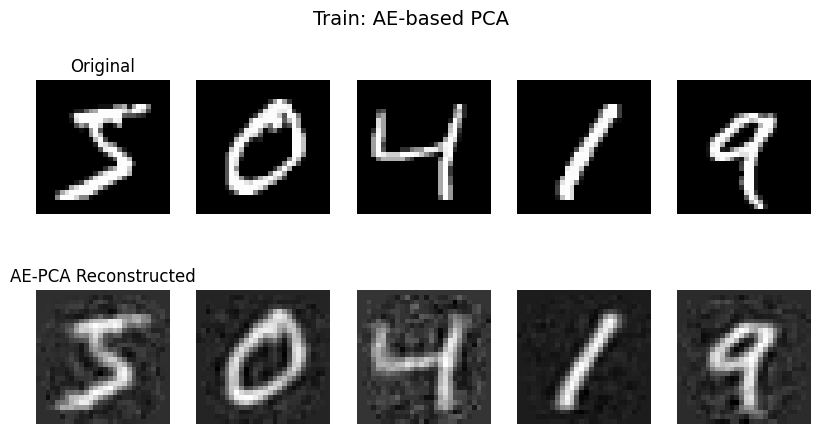

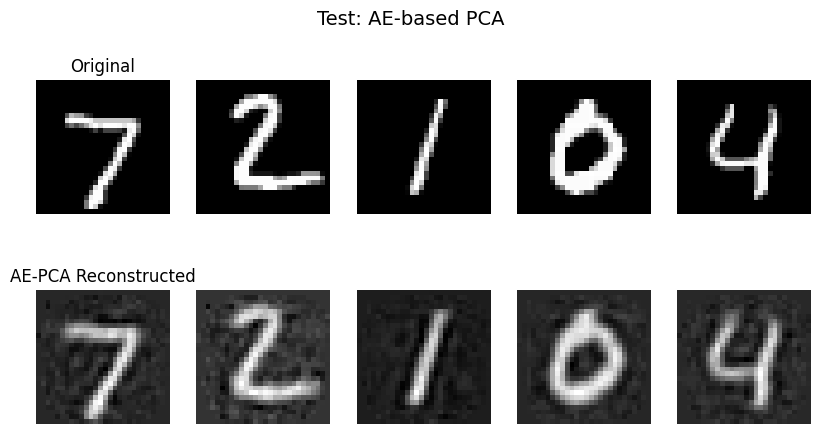

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt

###############################
# 1) AFTER TRAINING COMPLETES #
###############################
model.eval()

# Extract W2 (the decoder weight), which should have shape [784, 128]
# in this example.  Move it to CPU as a NumPy array.
with torch.no_grad():
    W2 = model.decoder.weight.data.clone().cpu().numpy()  # shape [784, latent_size]

print("W2 shape:", W2.shape)

# SVD on W2.  The left singular vectors in U are effectively the PCA axes (up to sign).
#   W2 = U * Sigma * Vt
# where U.shape = [784, 128], Sigma.shape = [128], Vt.shape = [128, 128]
U, S, Vt = np.linalg.svd(W2, full_matrices=False)

# Columns of U are the principal directions in 784-D space.
pca_components_from_ae = U  # shape [784, 128]


num_components_to_show = 8
plt.figure(figsize=(10, 2))
for i in range(num_components_to_show):
    plt.subplot(1, num_components_to_show, i + 1)
    # Take the i-th column of U (which is size 784), reshape to 28×28
    comp_img = U[:, i].reshape(28, 28)
    plt.imshow(comp_img, cmap='gray')
    plt.title(f"Comp {i+1}")
    plt.axis('off')

plt.suptitle("First 8 Principal Directions from Autoencoder Weights", fontsize=14)
plt.show()
#####################################
# 2) COMPRESS & RECONSTRUCT (TRAIN) #
#####################################

# We already have 'train_data' of shape [N_train, 784]
# and 'mean_image' of shape [784].
# Make sure the data is centered just like in classical PCA:
centered_train = train_data - mean_image  # shape [N_train, 784]

# Compress by projecting onto the columns of U (i.e., onto AE-based PCA directions)
compressed_train_ae = centered_train @ pca_components_from_ae  # shape [N_train, 128]

# Reconstruct
reconstructed_train_ae = compressed_train_ae @ pca_components_from_ae.T + mean_image

###################################
# 3) COMPRESS & RECONSTRUCT (TEST) #
###################################
centered_test = test_data - mean_image  # shape [N_test, 784]
compressed_test_ae = centered_test @ pca_components_from_ae  # shape [N_test, 128]
reconstructed_test_ae = compressed_test_ae @ pca_components_from_ae.T + mean_image

###################################
# 4) VISUALIZE A FEW RECONSTRUCTIONS
###################################
def plot_reconstructions(original, reconstructed, num_samples=5, title="AE-PCA Reconstruction"):
    plt.figure(figsize=(10,5))
    for i in range(num_samples):
        # Original
        plt.subplot(2, num_samples, i+1)
        plt.imshow(original[i].reshape(28,28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("Original")

        # Reconstructed
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(reconstructed[i].reshape(28,28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("AE-PCA Reconstructed")

    plt.suptitle(title, fontsize=14)
    plt.show()

# Compare 5 training images
plot_reconstructions(train_data, reconstructed_train_ae, title="Train: AE-based PCA")

# Compare 5 test images
plot_reconstructions(test_data, reconstructed_test_ae, title="Test: AE-based PCA")


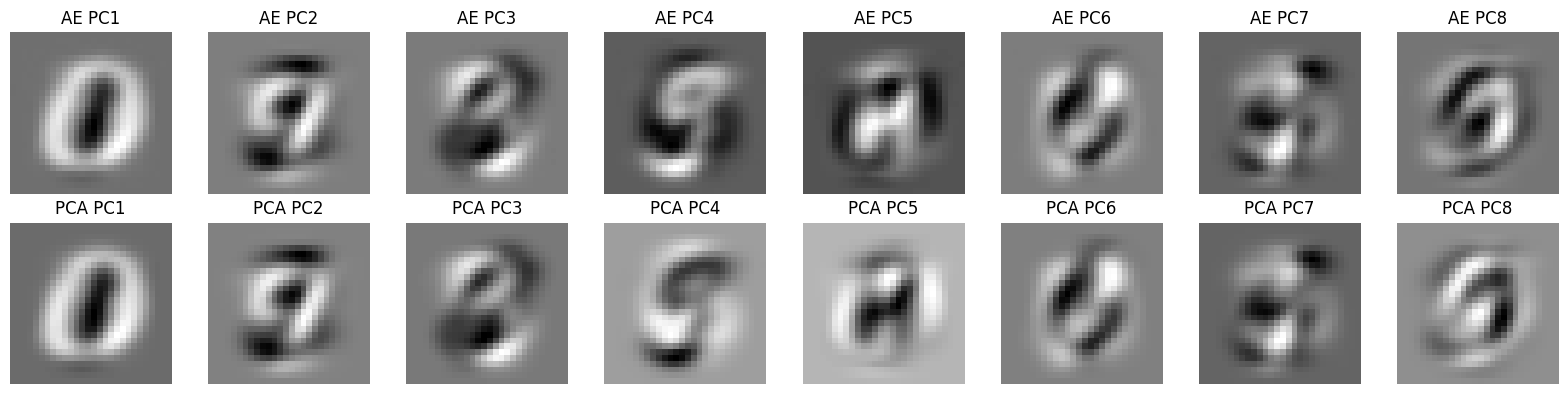

In [31]:
import matplotlib.pyplot as plt

def compare_components(ae_comps, pca_comps, n=8):
    """
    ae_comps, pca_comps: each shape [128, 784]
    We'll plot the first 'n' components side by side.
    """
    fig, axes = plt.subplots(2, n, figsize=(16,4))
    for i in range(n):
        # Autoencoder-based component (reshape 784 -> 28x28)
        comp_ae = ae_comps[i].reshape(28, 28)
        axes[0, i].imshow(comp_ae, cmap='gray')
        axes[0, i].set_title(f"AE PC{i+1}")
        axes[0, i].axis("off")

        # Classical PCA component
        comp_pca = pca_comps[i].reshape(28, 28)
        axes[1, i].imshow(comp_pca, cmap='gray')
        axes[1, i].set_title(f"PCA PC{i+1}")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

# Show side-by-side
compare_components(ae_components, pca_components, n=8)


In [32]:
import numpy as np
import torch

# 1) Suppose you already have:
#    (a) V_L, shape [128, 784], which is the top-128 principal components from classical PCA
#        Each row is a direction in 784-D.
#    (b) model.decoder.weight as W2, shape [784, 128] in your linear autoencoder

# Move autoencoder weight to CPU NumPy
with torch.no_grad():
    W2 = model.decoder.weight.data.clone().cpu().numpy()  # shape [784, 128]

# 2) SVD of W2 => W2 = U * Sigma * Vt
#    U.shape => [784, 128]
#    Each column of U is a 784-dim direction discovered by the AE
U_ae, S_ae, Vt_ae = np.linalg.svd(W2, full_matrices=False)

# 3) Convert V_L so that each column is a direction (to match shape):
#    Right now, V_L is shape [128, 784], with each row = a 784-D direction.
#    Let's transpose it: shape [784, 128], so each column is a direction.
V_L_t = V_L.T  # shape [784, 128]

# 4) Compare each of the 128 directions from AE (U_ae) vs. PCA (V_L_t)

mse_list = []
cosine_list = []
for i in range(128):
    ae_vec = U_ae[:, i]          # 784-D
    pca_vec = V_L_t[:, i]        # 784-D

    # -- Align signs so they point roughly in the same direction
    sign_flip = np.sign(np.dot(ae_vec, pca_vec))
    ae_vec_aligned = sign_flip * ae_vec

    # -- Compute MSE
    mse = np.mean((ae_vec_aligned - pca_vec)**2)

    # -- Compute Cosine similarity
    num = np.dot(ae_vec_aligned, pca_vec)
    den = np.linalg.norm(ae_vec_aligned) * np.linalg.norm(pca_vec)
    cos_sim = num / den

    mse_list.append(mse)
    cosine_list.append(cos_sim)

# 5) Print out some summary stats:
print("Per-component MSE:")
print(mse_list[:10], "...")  # show first 10 for brevity

print("Per-component Cosine similarity:")
print(cosine_list[:10], "...")

print(f"Average MSE over all 128 components: {np.mean(mse_list):.6f}")
print(f"Average cosine similarity over all 128 components: {np.mean(cosine_list):.6f}")


Per-component MSE:
[5.1030044216934955e-06, 2.3997187127333774e-06, 1.3328789344069718e-05, 2.70560200557433e-05, 2.6845402690043184e-05, 2.3368923611489767e-06, 3.745318872932701e-06, 1.1944681209402647e-05, 1.1629464952421631e-05, 4.2962620402127054e-06] ...
Per-component Cosine similarity:
[0.997999620413883, 0.9990593097025134, 0.9947751134834396, 0.9893941010745597, 0.9894766626018967, 0.9990839395872302, 0.9985318914853213, 0.9953176872133355, 0.9954412444006697, 0.9983159229105976] ...
Average MSE over all 128 components: 0.001513
Average cosine similarity over all 128 components: 0.407095


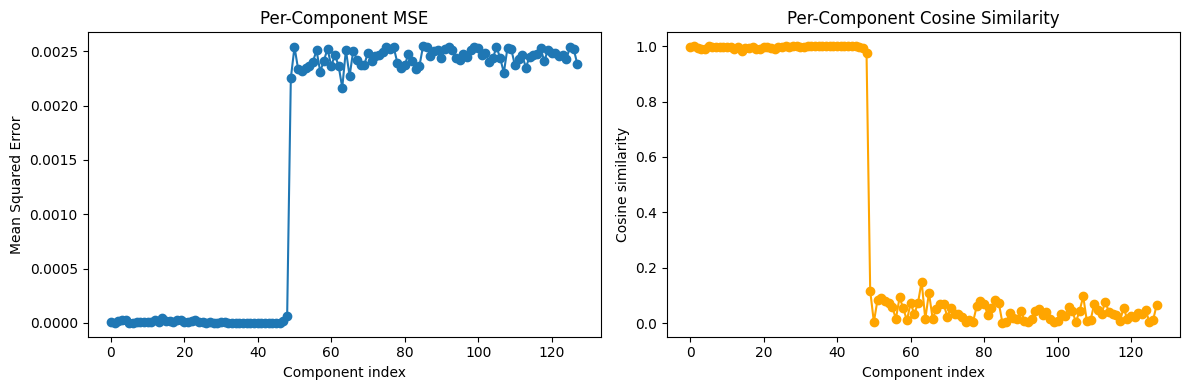

In [33]:
import matplotlib.pyplot as plt

# Suppose mse_list and cosine_list each have length 128
# from the comparison of each AE component vs. PCA component.

plt.figure(figsize=(12, 4))

# Left subplot: MSE
plt.subplot(1, 2, 1)
plt.plot(mse_list, marker='o')
plt.title("Per-Component MSE")
plt.xlabel("Component index")
plt.ylabel("Mean Squared Error")

# Right subplot: Cosine similarity
plt.subplot(1, 2, 2)
plt.plot(cosine_list, marker='o', color='orange')
plt.title("Per-Component Cosine Similarity")
plt.xlabel("Component index")
plt.ylabel("Cosine similarity")

plt.tight_layout()
plt.show()


Total parameters in the 3-layer Nonlinear AE: 935824
[Nonlinear AE] Epoch [1/40], Train Loss: 0.0193, Test Loss: 0.0097
[Nonlinear AE] Epoch [2/40], Train Loss: 0.0084, Test Loss: 0.0073
[Nonlinear AE] Epoch [3/40], Train Loss: 0.0069, Test Loss: 0.0063
[Nonlinear AE] Epoch [4/40], Train Loss: 0.0061, Test Loss: 0.0058
[Nonlinear AE] Epoch [5/40], Train Loss: 0.0056, Test Loss: 0.0053
[Nonlinear AE] Epoch [6/40], Train Loss: 0.0054, Test Loss: 0.0052
[Nonlinear AE] Epoch [7/40], Train Loss: 0.0052, Test Loss: 0.0051
[Nonlinear AE] Epoch [8/40], Train Loss: 0.0051, Test Loss: 0.0050
[Nonlinear AE] Epoch [9/40], Train Loss: 0.0050, Test Loss: 0.0049
[Nonlinear AE] Epoch [10/40], Train Loss: 0.0050, Test Loss: 0.0048
[Nonlinear AE] Epoch [11/40], Train Loss: 0.0049, Test Loss: 0.0048
[Nonlinear AE] Epoch [12/40], Train Loss: 0.0049, Test Loss: 0.0047
[Nonlinear AE] Epoch [13/40], Train Loss: 0.0048, Test Loss: 0.0048
[Nonlinear AE] Epoch [14/40], Train Loss: 0.0048, Test Loss: 0.0047
[Non

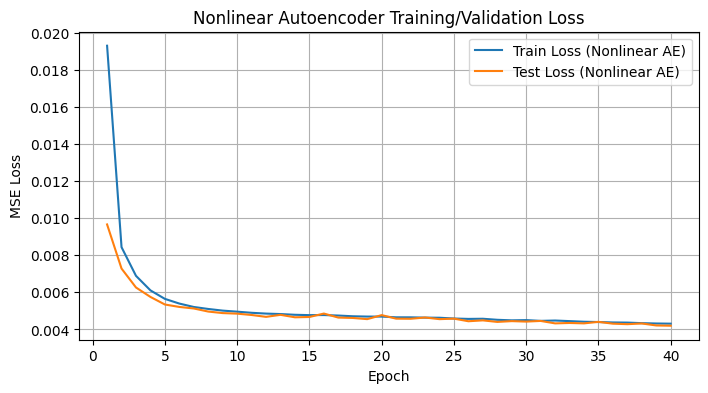

In [42]:
#############################################
# Question 2: 3-Layer Nonlinear Autoencoder #
#############################################
import torch
import torch.nn as nn
import torch.optim as optim

centered_test = test_data - mean_image  # same as mean_centered_train
test_tensor = torch.from_numpy(centered_test).float()
test_dataset = torch.utils.data.TensorDataset(test_tensor, torch.zeros(len(test_tensor)))
# Use a small batch size to mimic the paper's setting (adjust if needed)
test_loader = DataLoader(test_dataset, batch_size=250, shuffle=True)

# Define a 3-layer non-linear AE (2 hidden layers in encoder and decoder)
class NonLinearAutoencoder(nn.Module):
    def __init__(self):
        super(NonLinearAutoencoder, self).__init__()
        # Encoder: 784 -> 512 -> 128
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU()
        )
        # Decoder: 128 -> 512 -> 784
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 784)
            # Optionally, you could add a Sigmoid here if you prefer outputs in [0,1].
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

# Create and move model to device
nonlinear_ae = NonLinearAutoencoder().to(device)

# Print the total number of parameters
param_count = sum(p.numel() for p in nonlinear_ae.parameters())
print(f"Total parameters in the 3-layer Nonlinear AE: {param_count}")

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(nonlinear_ae.parameters(), lr=1e-3)

EPOCHS_NONLIN = 40  # Adjust as desired
train_losses_nonlin = []
test_losses_nonlin = []

# Train loop (similar to the linear AE code)
for epoch in range(EPOCHS_NONLIN):
    nonlinear_ae.train()
    train_loss = 0.0
    for batch_x, _ in train_loader:
        batch_x = batch_x.to(device)
        optimizer.zero_grad()
        outputs = nonlinear_ae(batch_x)
        loss = criterion(outputs, batch_x)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses_nonlin.append(train_loss)

    # Evaluate on test set
    nonlinear_ae.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_x, _ in test_loader:
            batch_x = batch_x.to(device)
            outputs = nonlinear_ae(batch_x)
            loss = criterion(outputs, batch_x)
            test_loss += loss.item()
    test_loss /= len(test_loader)
    test_losses_nonlin.append(test_loss)

    print(f"[Nonlinear AE] Epoch [{epoch+1}/{EPOCHS_NONLIN}], "
          f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

param_count = sum(p.numel() for p in nonlinear_ae.parameters())
print(f"Total parameters in 3-layer Nonlinear AE: {param_count}")

# (Optional) Plot losses
plt.figure(figsize=(8,4))
plt.plot(range(1, EPOCHS_NONLIN+1), train_losses_nonlin, label='Train Loss (Nonlinear AE)')
plt.plot(range(1, EPOCHS_NONLIN+1), test_losses_nonlin, label='Test Loss (Nonlinear AE)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Nonlinear Autoencoder Training/Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class TiedNonlinearAutoencoder(nn.Module):
    def __init__(self, enc_neg_slope=0.2):
        super().__init__()
        # "Encoder" layers:
        # εδώ ορίζουμε ΜΟΝΟ τις μήτρες βαρών για 784->512 και 512->128
        self.fc1 = nn.Linear(784, 512, bias=False)
        self.fc2 = nn.Linear(512, 128, bias=False)

        # ορίζουμε κλίση Leaky ReLU στον encoder
        self.enc_neg_slope = enc_neg_slope
        # στον decoder χρειαζόμαστε κλίση = 1 / enc_neg_slope, δηλ. 5 αν enc_neg_slope=0.2
        self.dec_neg_slope = 1.0 / enc_neg_slope

    def encode(self, x):
        # x: [batch_size, 784]
        x = F.leaky_relu(self.fc1(x), negative_slope=self.enc_neg_slope)
        x = F.leaky_relu(self.fc2(x), negative_slope=self.enc_neg_slope)
        return x  # [batch_size, 128]

    def decode(self, z):
        # Χρησιμοποιούμε τα transpose των βαρών
        # αντί για ανεξάρτητες nn.Linear
        z = torch.matmul(z, self.fc2.weight)  # (batch, 512)
        z = F.leaky_relu(z, negative_slope=self.dec_neg_slope)
        z = torch.matmul(z, self.fc1.weight)  # (batch, 784)
        # εδώ θα μπορούσαμε να βάλουμε π.χ. torch.sigmoid() αν θέλαμε [0,1] αλλά δεν είναι υποχρεωτικό
        return z

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon

# Παράδειγμα δημιουργίας και εκτύπωσης πλήθους παραμέτρων:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_tied = TiedNonlinearAutoencoder(enc_neg_slope=0.2).to(device)

# Θα δείτε ~το μισό (χωρίς biases) σε σχέση με τον "κανονικό" AE
total_params = sum(p.numel() for p in model_tied.parameters())
print(f"Συνολικοί παράμετροι (tied AE): {total_params}")


Συνολικοί παράμετροι (tied AE): 466944


In [63]:
# Ορίζουμε optimizer, loss κλπ.
criterion = nn.MSELoss()
optimizer = optim.Adam(model_tied.parameters(), lr=1e-3)

tiednonlinear_losses = []

EPOCHS_TIED = 40
for epoch in range(EPOCHS_TIED):
    model_tied.train()
    epoch_loss = 0.0
    for batch_x, _ in train_loader:  # train_loader όπως ορίστηκε πριν
        batch_x = batch_x.to(device)
        optimizer.zero_grad()
        outputs = model_tied(batch_x)
        loss = criterion(outputs, batch_x)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    tiednonlinear_losses.append(epoch_loss)
    print(f"[Tied AE] Epoch {epoch+1}/{EPOCHS_TIED}, Train Loss: {epoch_loss:.4f}")


[Tied AE] Epoch 1/40, Train Loss: 0.0037
[Tied AE] Epoch 2/40, Train Loss: 0.0032
[Tied AE] Epoch 3/40, Train Loss: 0.0032
[Tied AE] Epoch 4/40, Train Loss: 0.0032
[Tied AE] Epoch 5/40, Train Loss: 0.0032
[Tied AE] Epoch 6/40, Train Loss: 0.0032
[Tied AE] Epoch 7/40, Train Loss: 0.0032
[Tied AE] Epoch 8/40, Train Loss: 0.0032
[Tied AE] Epoch 9/40, Train Loss: 0.0031
[Tied AE] Epoch 10/40, Train Loss: 0.0031
[Tied AE] Epoch 11/40, Train Loss: 0.0031
[Tied AE] Epoch 12/40, Train Loss: 0.0031
[Tied AE] Epoch 13/40, Train Loss: 0.0031
[Tied AE] Epoch 14/40, Train Loss: 0.0031
[Tied AE] Epoch 15/40, Train Loss: 0.0031
[Tied AE] Epoch 16/40, Train Loss: 0.0031
[Tied AE] Epoch 17/40, Train Loss: 0.0031
[Tied AE] Epoch 18/40, Train Loss: 0.0031
[Tied AE] Epoch 19/40, Train Loss: 0.0031
[Tied AE] Epoch 20/40, Train Loss: 0.0030
[Tied AE] Epoch 21/40, Train Loss: 0.0030
[Tied AE] Epoch 22/40, Train Loss: 0.0030
[Tied AE] Epoch 23/40, Train Loss: 0.0030
[Tied AE] Epoch 24/40, Train Loss: 0.0030
[

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class PseudoTiedNonlinearAutoencoder(nn.Module):
    def __init__(self, enc_neg_slope=0.2):
        super().__init__()
        # Encoder: define two fully connected layers (without bias)
        self.fc1 = nn.Linear(784, 512, bias=False)
        self.fc2 = nn.Linear(512, 128, bias=False)

        self.enc_neg_slope = enc_neg_slope
        # For inversion of the negative slope in the decoder:
        self.dec_neg_slope = 1.0 / enc_neg_slope

    def encode(self, x):
        # Apply encoder layers with LeakyReLU (slope=0.2)
        x = F.leaky_relu(self.fc1(x), negative_slope=self.enc_neg_slope)
        x = F.leaky_relu(self.fc2(x), negative_slope=self.enc_neg_slope)
        return x  # latent representation of shape (batch, 128)

    def decode(self, z):
        # For the decoder, we use the pseudoinverse of the encoder weights.
        # Compute pseudoinverse for fc2:
        # fc2.weight shape: (128, 512)
        # Pseudo-inverse (transposed version): (A A^T)^{-1} A, shape: (128,512)
        pseudo_inv_fc2 = torch.inverse(self.fc2.weight @ self.fc2.weight.T) @ self.fc2.weight
        # Multiply latent vector (batch,128) with pseudo_inv_fc2 (128,512) -> (batch,512)
        z = torch.matmul(z, pseudo_inv_fc2)
        # Apply LeakyReLU with negative slope = 5 (i.e. 1/0.2) to invert the encoder’s activation for negatives
        z = F.leaky_relu(z, negative_slope=self.dec_neg_slope)

        # Compute pseudoinverse for fc1:
        # fc1.weight shape: (512, 784)
        pseudo_inv_fc1 = torch.inverse(self.fc1.weight @ self.fc1.weight.T) @ self.fc1.weight
        # Multiply to get reconstructed input: (batch,512) @ (512,784) -> (batch,784)
        x_recon = torch.matmul(z, pseudo_inv_fc1)
        return x_recon

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon

# Create the pseudo-tied autoencoder and move it to the device (device already defined in previous cells)
model_pseudo = PseudoTiedNonlinearAutoencoder(enc_neg_slope=0.2).to(device)

# Print the total number of parameters (this should be roughly half of the untied version)
total_params_pseudo = sum(p.numel() for p in model_pseudo.parameters())
print(f"Total parameters in Pseudo-tied Nonlinear AE: {total_params_pseudo}")

# Define loss and optimizer (same as before)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_pseudo.parameters(), lr=1e-3)

pseudo_losses    = []

# Training loop for the pseudo-tied AE
EPOCHS_PSEUDO = 40
for epoch in range(EPOCHS_PSEUDO):
    model_pseudo.train()
    epoch_loss = 0.0
    for batch_x, _ in train_loader:
        batch_x = batch_x.to(device)
        optimizer.zero_grad()
        outputs = model_pseudo(batch_x)
        loss = criterion(outputs, batch_x)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    pseudo_losses.append(epoch_loss)
    print(f"[Pseudo-Tied AE] Epoch {epoch+1}/{EPOCHS_PSEUDO}, Train Loss: {epoch_loss:.4f}")


Total parameters in Pseudo-tied Nonlinear AE: 466944
[Pseudo-Tied AE] Epoch 1/40, Train Loss: 0.0207
[Pseudo-Tied AE] Epoch 2/40, Train Loss: 0.0097
[Pseudo-Tied AE] Epoch 3/40, Train Loss: 0.0077
[Pseudo-Tied AE] Epoch 4/40, Train Loss: 0.0063
[Pseudo-Tied AE] Epoch 5/40, Train Loss: 0.0057
[Pseudo-Tied AE] Epoch 6/40, Train Loss: 0.0054
[Pseudo-Tied AE] Epoch 7/40, Train Loss: 0.0052
[Pseudo-Tied AE] Epoch 8/40, Train Loss: 0.0051
[Pseudo-Tied AE] Epoch 9/40, Train Loss: 0.0049
[Pseudo-Tied AE] Epoch 10/40, Train Loss: 0.0049
[Pseudo-Tied AE] Epoch 11/40, Train Loss: 0.0048
[Pseudo-Tied AE] Epoch 12/40, Train Loss: 0.0047
[Pseudo-Tied AE] Epoch 13/40, Train Loss: 0.0046
[Pseudo-Tied AE] Epoch 14/40, Train Loss: 0.0046
[Pseudo-Tied AE] Epoch 15/40, Train Loss: 0.0045
[Pseudo-Tied AE] Epoch 16/40, Train Loss: 0.0045
[Pseudo-Tied AE] Epoch 17/40, Train Loss: 0.0045
[Pseudo-Tied AE] Epoch 18/40, Train Loss: 0.0044
[Pseudo-Tied AE] Epoch 19/40, Train Loss: 0.0044
[Pseudo-Tied AE] Epoch 20

Mean Squared Reconstruction Error on Test Data
------------------------------------------------
Nonlinear AE                  : 3.291570
Tied Nonlinear AE             : 2.291164
Pseudo-tied Nonlinear AE      : 2.911949


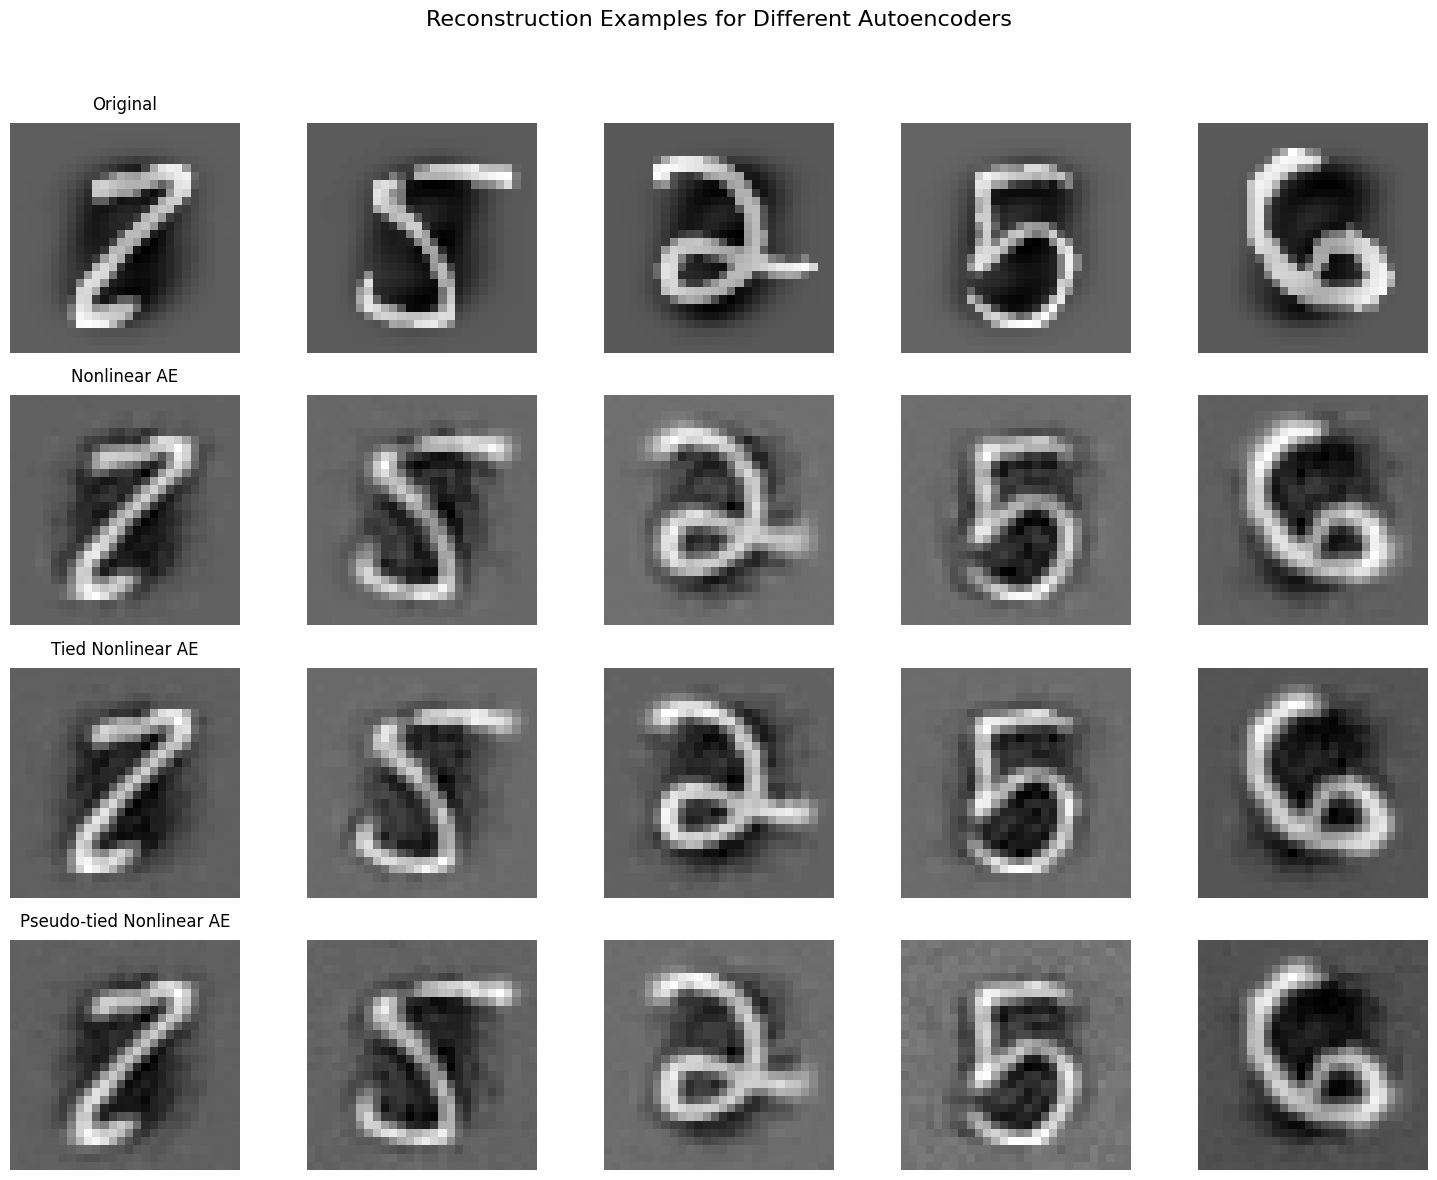

In [68]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Dictionary of models: replace "Linear AE" with "Tied Nonlinear AE"
models = {
    "Nonlinear AE": nonlinear_ae,
    "Tied Nonlinear AE": model_tied,
    "Pseudo-tied Nonlinear AE": model_pseudo
}

# Set each model to evaluation mode
for name, model in models.items():
    model.eval()

# Calculate the Mean Squared Reconstruction Error (MSE) on the test set for each model
test_mse = {}
with torch.no_grad():
    for name, model in models.items():
        total_loss = 0.0
        total_samples = 0
        for batch_x, _ in test_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            loss = F.mse_loss(outputs, batch_x, reduction='sum')
            total_loss += loss.item()
            total_samples += batch_x.size(0)
        test_mse[name] = total_loss / total_samples

# Print a summary table with the test MSE for each model
print("Mean Squared Reconstruction Error on Test Data")
print("------------------------------------------------")
for name, mse in test_mse.items():
    print(f"{name:30s}: {mse:.6f}")

# Now, display a few reconstruction examples.
# We'll take one batch from test_loader and pick 5 samples from it.
with torch.no_grad():
    batch_x, _ = next(iter(test_loader))
    batch_x = batch_x.to(device)
    # Get reconstructions from each model
    reconstructions = {}
    for name, model in models.items():
        reconstructions[name] = model(batch_x).cpu().numpy()

# Also get the original images (convert to numpy)
original = batch_x.cpu().numpy()

# Plot the results:
# Create a grid where the first row shows original images,
# and each subsequent row shows reconstructions from a different AE.
num_samples = 5
num_rows = 1 + len(models)  # one row for original and one per model
fig, axes = plt.subplots(nrows=num_rows, ncols=num_samples, figsize=(15, 3 * num_rows))

# First row: Original images
for i in range(num_samples):
    axes[0, i].imshow(original[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis("off")
# Label the first image in the first row
axes[0, 0].set_title("Original", fontsize=12, pad=10)

# Subsequent rows: reconstructions from each model with label at the top of the first image in each row
row = 1
for name, recon in reconstructions.items():
    for i in range(num_samples):
        axes[row, i].imshow(recon[i].reshape(28, 28), cmap='gray')
        axes[row, i].axis("off")
    # Set the title at the top of the first image in this row
    axes[row, 0].set_title(name, fontsize=12, pad=10)
    row += 1

plt.suptitle("Reconstruction Examples for Different Autoencoders", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


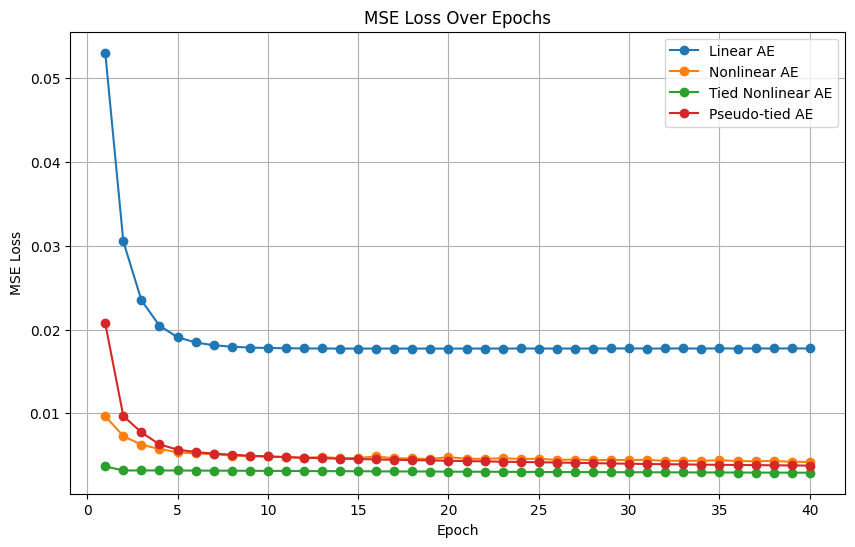

In [69]:
###########################
# Plotting Training Losses
###########################
EPOCHS = 40
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), linear_losses, marker='o', linestyle='-', label='Linear AE')
plt.plot(range(1, EPOCHS+1), test_losses_nonlin, marker='o', linestyle='-', label='Nonlinear AE')
plt.plot(range(1, EPOCHS+1), tiednonlinear_losses, marker='o', linestyle='-', label='Tied Nonlinear AE')
plt.plot(range(1, EPOCHS+1), pseudo_losses, marker='o', linestyle='-', label='Pseudo-tied AE')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("MSE Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()